In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import warnings
warnings.filterwarnings("ignore")
pd.set_option('max_column', None)

# Load the Data and Make Transformations

In [2]:
train_df=pd.read_csv('../data/train.csv')
store_df=pd.read_csv('../data/store.csv')
test_df=pd.read_csv('../data/test.csv')

In [3]:
#convert date column to date type and make it an index
def get_date_type(df):
    df['Date']=pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.weekofyear
    return df
train_df=get_date_type(train_df)

In [4]:
store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median(), inplace = True)
#merge the train data with store data
train_store=train_df.merge(store_df,on='Store')
train_store.fillna(0, inplace=True)
train_store=get_date_type(train_store)
# train_store.head()


In [8]:
storeSales= train_store[['Date', 'Sales']]
storeSales.head()

,Date,Sales
0,2015-07-31,5263
1,2015-07-30,5020
2,2015-07-29,4782
3,2015-07-28,5011
4,2015-07-27,6102


In [9]:
scaler = MinMaxScaler()
storeSales['storeSalesScaled'] = scaler.fit_transform(storeSales[['Sales']])

# storeSales.head()

In [10]:
storeSales=storeSales[:50000]
storeSales.tail()

,Date,Sales,storeSalesScaled
49995,2013-06-08,2466,0.059349
49996,2013-06-07,3984,0.095882
49997,2013-06-06,4037,0.097158
49998,2013-06-05,3895,0.093740
49999,2013-06-04,4059,0.097687


### Unit Root Tests.
Unit Root Tests helps us determine the stationarity of our data

In [11]:
#Unit Root Tests helps us determine the stationarity of our data
adfResult = adfuller(storeSales.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -8.548705443043678
p-value: 9.349567942752572e-14


In [ ]:
#Unit Root Tests helps us determine the stationarity of our data
adfResult = adfuller(storeSales.storeSalesScaled.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

#### Removing Stationarity
The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

In [12]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [13]:
storeSalesDif = difference(storeSales.storeSalesScaled.values)

In [14]:
storeSalesDif

0       -0.005848
1       -0.005728
2        0.005511
3        0.026257
4       -0.146856
           ...   
49994    0.059349
49995    0.036533
49996    0.001276
49997   -0.003417
49998    0.003947
Length: 49999, dtype: float64

#### Autocorrelations and Partial Autocorrelations Plots.
We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

In [15]:
acfSalesScaled = acf(storeSales.storeSalesScaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

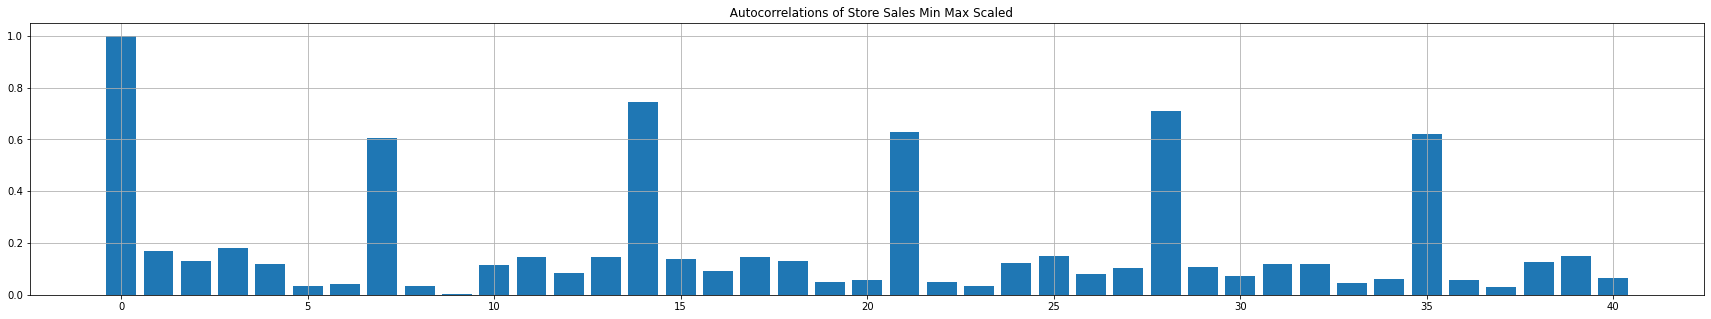

In [16]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of Store Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()
corrPlots(acfSalesScaledNp, '')

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed

In [17]:
pacfSalesScaled = pacf(storeSales.storeSalesScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

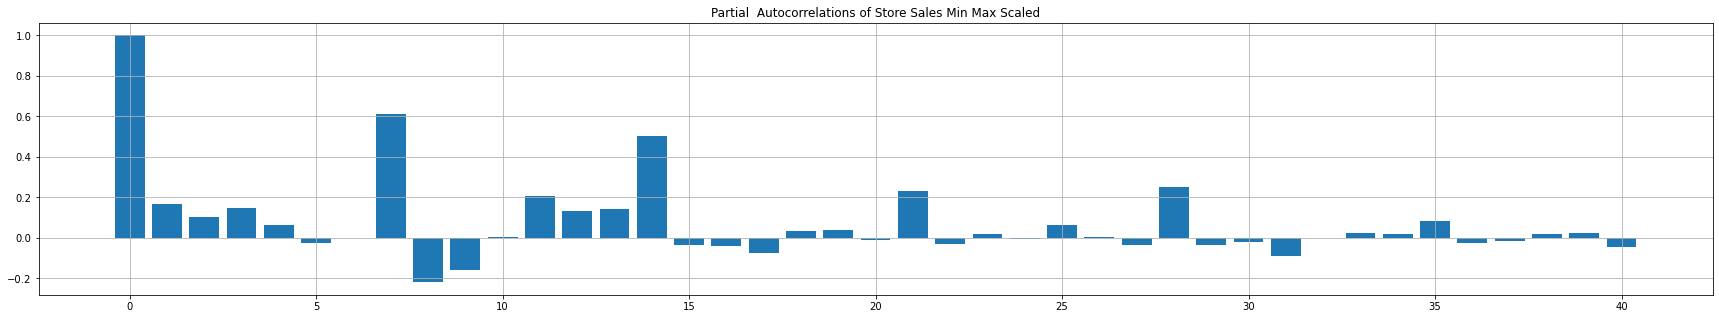

In [18]:
corrPlots(pacfSalesScaledNp, "Partial")

## Separating into a Training and Validation Set Fomat to Use Feed into LSTM.

In [19]:
SIZE = len(storeSales.storeSalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [21]:
DateTrain = storeSales.index.values[0:BATCH_SIZE]
DateValid = storeSales.index.values[BATCH_SIZE:]
XTrain = storeSales.storeSalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = storeSales.storeSalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (49904, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (49904,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [22]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([49904, 1])

In [23]:
#create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset shapes: (1,), types: tf.float32>

In [24]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)

In [25]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [26]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [27]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [28]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [29]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [30]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

## Define and Estimate the LSTM.

In [31]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

The Huber loss is chosen because it is quite robust for non linear regression models and models with non normal errors.

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 8)           320       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 14s 14s/step - loss: 0.0182 - val_loss: 0.0042
Epoch 2/200
1/1 [==============================] - 10s 10s/step - loss: 0.0170 - val_loss: 0.0037
Epoch 3/200
1/1 [==============================] - 10s 10s/step - loss: 0.0159 - val_loss: 0.0032
Epoch 4/200
1/1 [==============================] - 10s 10s/step - loss: 0.0148 - val_loss: 0.0028
Epoch 5/200
1/1 [==============================] - 10s 10s/step - loss: 0.0138 - val_loss: 0.0024
Epoch 6/200
1/1 [==============================] - 10s 10s/step - loss: 0.0128 - val_loss: 0.0020
Epoch 7/200
1/1 [==============================] - 10s 10s/step - loss: 0.0119 - val_loss: 0.0017
Epoch 8/200
1/1 [==============================] - 10s 10s/step - loss: 0.0111 - val_loss: 0.0014
Epoch 9/200
1/1 [==============================] - 10s 10s/step - loss: 0.0102 - val_loss: 0.0012
Epoch 10/200
1/1 [==============================] - 9s 9s/step - loss: 0.0095 - val_loss: 0.0010
Epoch 11/200
1/1 [===

1/1 [==============================] - 9s 9s/step - loss: 0.0033 - val_loss: 0.0025
Epoch 85/200
1/1 [==============================] - 9s 9s/step - loss: 0.0033 - val_loss: 0.0025
Epoch 86/200
1/1 [==============================] - 10s 10s/step - loss: 0.0033 - val_loss: 0.0024
Epoch 87/200
1/1 [==============================] - 9s 9s/step - loss: 0.0033 - val_loss: 0.0024
Epoch 88/200
1/1 [==============================] - 9s 9s/step - loss: 0.0033 - val_loss: 0.0024
Epoch 89/200
1/1 [==============================] - 9s 9s/step - loss: 0.0033 - val_loss: 0.0024
Epoch 90/200
1/1 [==============================] - 9s 9s/step - loss: 0.0033 - val_loss: 0.0024
Epoch 91/200
1/1 [==============================] - 9s 9s/step - loss: 0.0033 - val_loss: 0.0024
Epoch 92/200
1/1 [==============================] - 10s 10s/step - loss: 0.0033 - val_loss: 0.0023
Epoch 93/200
1/1 [==============================] - 9s 9s/step - loss: 0.0033 - val_loss: 0.0023
Epoch 94/200
1/1 [=====================

1/1 [==============================] - 11s 11s/step - loss: 0.0031 - val_loss: 0.0016
Epoch 168/200
1/1 [==============================] - 9s 9s/step - loss: 0.0030 - val_loss: 0.0016
Epoch 169/200
1/1 [==============================] - 9s 9s/step - loss: 0.0030 - val_loss: 0.0016
Epoch 170/200
1/1 [==============================] - 9s 9s/step - loss: 0.0030 - val_loss: 0.0016
Epoch 171/200
1/1 [==============================] - 9s 9s/step - loss: 0.0030 - val_loss: 0.0016
Epoch 172/200
1/1 [==============================] - 9s 9s/step - loss: 0.0030 - val_loss: 0.0016
Epoch 173/200
1/1 [==============================] - 9s 9s/step - loss: 0.0030 - val_loss: 0.0015
Epoch 174/200
1/1 [==============================] - 9s 9s/step - loss: 0.0030 - val_loss: 0.0015
Epoch 175/200
1/1 [==============================] - 9s 9s/step - loss: 0.0030 - val_loss: 0.0015
Epoch 176/200
1/1 [==============================] - 10s 10s/step - loss: 0.0030 - val_loss: 0.0015
Epoch 177/200
1/1 [===========

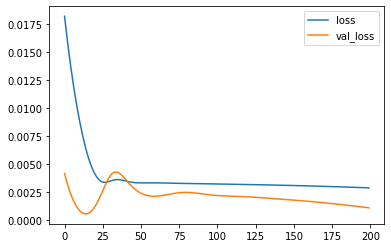

In [34]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

## Forecast the LSTM on the Validation Set and Assess Accuracy.

In [35]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [39]:
Forecast = model_forecast(model, storeSales.storeSalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

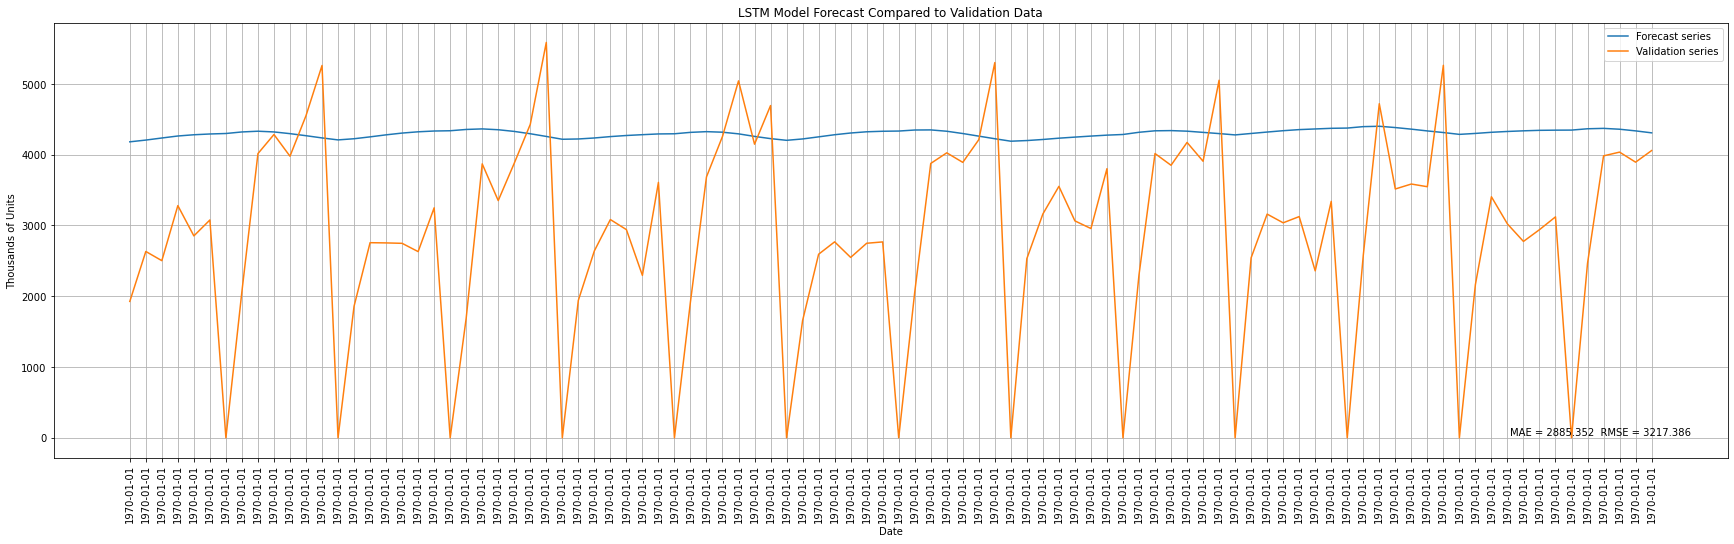

In [40]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [41]:
print(textstr)

MAE = 2885.352  RMSE = 3217.386
